In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import subplots
import os

## 1 - Data

### 1.1 Data Loading

Data was retrieved from Wharton Research Data Services.  Namely Accounting/fundamental annual data was downloaded from CRSP/Compustat Merged, monthly stock return and stock information of U.S. stock market was downloaded from CRSP.   During this section we are just creating/merging the dataframes according to the PERMNO (company indentifier).

In [92]:
stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)
stk_data['PRC'] = abs(stk_data['PRC'])
stk_data['MktCap_Mon'] = stk_data['PRC']*stk_data['SHROUT'] 
stk_data['date'] = pd.to_datetime(stk_data['date'], format='%Y-%m-%d')
stk_data['Year'] = stk_data['date'].dt.strftime('%Y')
stk_data['date'] = stk_data['date'].dt.strftime('%Y-%m')
stk_data

/var/folders/lv/4s79bs8j60n07b1d88ptj5l00000gn/T/ipykernel_28398/1407839232.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10000,1987-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987
1,10000,1987-02,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987
2,10000,1987-03,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987
3,10000,1987-04,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987
4,10000,1987-05,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3409591,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3409592,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3409593,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


In [93]:
FF_data = pd.read_csv("Data/F&F_Factors.csv")
FF_data.index = FF_data['dateff']
FF_data = FF_data.drop("dateff", axis=1)
FF_data.index = pd.to_datetime(FF_data.index, format="%Y-%m-%d").to_period('M')
FF_data.rename_axis('date', inplace=True)

In [94]:
Acc_Data = pd.read_csv("Data/Acc_Data2.csv", header=0)
Acc_Data = Acc_Data.rename(columns={'LPERMNO': 'PERMNO'})
Acc_Data = Acc_Data.rename(columns={'datadate': 'date'})
Acc_Data.drop_duplicates(subset=['PERMNO', 'date'], inplace=True, ignore_index=True)
Acc_Data['date'] = pd.to_datetime(Acc_Data['date'])
Acc_Data['date'] = Acc_Data['date'].dt.year
Acc_Data.sort_values(by=['PERMNO','date'])

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt
86969,12994,1987,INDL,C,D,STD,USD,5.4178,2.750,NaN,0.32,5.369,I,LC,10001,1987-06-30
86970,12994,1988,INDL,C,D,STD,USD,5.5565,2.555,NaN,0.57,5.512,I,LC,10001,1988-06-30
86971,12994,1989,INDL,C,D,STD,USD,6.3147,7.370,NaN,1.21,6.321,I,LC,10001,1989-06-30
86972,12994,1990,INDL,C,D,STD,USD,6.9631,7.175,NaN,1.10,7.179,I,LC,10001,1990-06-29
86973,12994,1991,INDL,C,D,STD,USD,7.4390,6.965,NaN,1.01,7.982,I,LC,10001,1991-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230345,184996,2019,INDL,C,D,STD,USD,36.5635,12627.000,14697.0,-4.92,6618.000,A,LC,93436,2019-12-31
230346,184996,2020,INDL,C,D,STD,USD,23.1510,10888.000,13347.0,0.64,22225.000,A,LC,93436,2020-12-31
230347,184996,2021,INDL,C,D,STD,USD,29.2246,6916.000,8873.0,4.90,30189.000,A,LC,93436,2021-12-31
230348,184996,2022,INDL,C,D,STD,USD,14.1290,3761.000,5748.0,3.62,44704.000,A,LC,93436,2022-12-30


# 2 - Strategies Evaluation

## 2.1 Quality Strategy

### 2.1.1 Defining Quality Score

Quality score is built based on the MSCI quality index metodology (see below some links for information from MSCI)  Here we construct the Return on Equity and the Debt to equity components.  Below there is a function for the EVAR. 

https://www.msci.com/documents/1296102/8473352/Quality-brochure.pdf  https://www.msci.com/documents/10199/96bc76ad-a6cf-477c-a967-9b0132146b90  https://www.msci.com/eqb/methodology/meth_docs/MSCI_Fundamental_Data_Methodology_Mar2020.pdf  https://www.msci.com/eqb/methodology/meth_docs/MSCI_Jun17_Fundamental_Data.pdf 

In [95]:
Acc_Data['ROE'] = Acc_Data['epsfi']/Acc_Data['bkvlps']
Acc_Data['DtE_Rat'] = Acc_Data['dltt']/Acc_Data['seq']
Acc_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
0,1001,1985,INDL,C,D,STD,USD,3.2633,11.908,NaN,0.68,13.014,I,LU,10015,1985-12-31,0.208378,0.915015
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236390,347085,2023,INDL,C,D,STD,USD,4.6842,5.786,9.844,1.05,144.982,A,LC,21069,2023-02-28,0.224158,0.039908
236391,348615,2023,INDL,C,D,STD,USD,2.9612,4.795,11.642,-0.48,97.590,A,LC,23424,2023-12-29,-0.162096,0.049134
236392,348892,2022,INDL,C,D,STD,USD,0.5382,3.109,3.503,-2.26,7.883,A,LC,20846,2022-12-30,-4.199182,0.394393
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [96]:
Quality_df = Acc_Data
company_years = Quality_df.groupby('PERMNO')['date'].nunique()
companies_with_5_years = company_years[company_years >= 5].index
companies_with_5_years

Acc_data_filtered = Acc_Data[Acc_Data['PERMNO'].isin(companies_with_5_years)]
Acc_data_filtered

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [97]:
def calculate_evar(group):
    if len(group) > 4:
        group['EPSg'] = group['epsfi'].pct_change() * 100
        group.loc[4:, 'EVAR'] = group['EPSg'].rolling(window=4).std(ddof=1)
        
    else:
        group['EVAR'] = 0
        
    return group

In [98]:
Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)
Acc_data_filtered

/var/folders/lv/4s79bs8j60n07b1d88ptj5l00000gn/T/ipykernel_28398/3759281452.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)


,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat,EPSg,EVAR
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476,NaN,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816,233.333333,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734,-76.666667,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082,-4271.428571,NaN
5,1003,1990,INDL,C,D,STD,USD,-0.1551,0.076,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,-0.182692,-97.260274,2150.937866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236372,332115,2022,INDL,C,D,STD,USD,0.9982,31.804,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,0.881486,12.500000,77.771864
236388,347007,2022,INDL,C,D,STD,USD,-1.0611,289.286,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-0.646699,16.853933,30.756963
236389,347007,2023,INDL,C,D,STD,USD,-0.8750,876.894,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.493890,10.576923,31.164466
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000,-57.598039,109.489869


This function builds the quality factor given Return on equity, debt to equity and Earnings variability. Conditions also defined by MSCI.

In [99]:
def Q_score(df):
    mean_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].mean()
    std_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].std()

    df = df.merge(mean_per_year, on='date', suffixes=('', '_mean'))
    df = df.merge(std_per_year, on='date', suffixes=('', '_std'))

    df['ROE Z-Score'] = (df['ROE'] - df['ROE_mean']) / df['ROE_std']
    df['DtE_Rat Z-Score'] = (df['DtE_Rat'] - df['DtE_Rat_mean']) / df['DtE_Rat_std']
    df['EVAR Z-Score'] = (df['EVAR'] - df['EVAR_mean']) / df['EVAR_std']

    df['Quality Z-Score'] = df[['ROE Z-Score', 'DtE_Rat Z-Score', 'EVAR Z-Score']].mean(axis=1)
    
    conditions = [
        (df['ROE'].isnull()), # If ROE is missing
        (df['DtE_Rat'].isnull()) & (~df['EVAR'].isnull()), # If only DtE_Rat is missing
        (~df['DtE_Rat'].isnull()) & (df['EVAR'].isnull()), # If only EVAR is missing
        (df[['ROE', 'DtE_Rat', 'EVAR']].isnull().sum(axis=1) >= 2) # If more than 2 values are missing
    ]
    choices = [
        np.nan, # If ROE is missing
        (df['ROE Z-Score'] + df['EVAR Z-Score']) / 2, # If only DtE_Rat is missing
        (df['ROE Z-Score'] + df['DtE_Rat Z-Score']) / 2, # If only EVAR is missing
        np.nan # If more than 2 values are missing
    ]
    df['Quality Z-Score'] = np.select(conditions, choices, default=df['Quality Z-Score'])

    df['Quality Score'] = df['Quality Z-Score'].apply(lambda x: (1 + x) if x >= 0 else (1 - x)**(-1) if not np.isnan(x) else np.nan)
    
    return df

In [100]:
Quality_df = Acc_data_filtered
Quality_df = Q_score(Quality_df)
Quality_df['date'] = pd.to_datetime(Quality_df['date'], format= "%Y")
Quality_df['date'] = Quality_df['date'].dt.strftime('%Y')
Quality_df = Quality_df[['date', 'PERMNO', 'Quality Score']]
Quality_df.rename(columns={'date': 'Year'}, inplace=True)
Quality_df

,Year,PERMNO,Quality Score
0,1986,10031,1.004270
1,1986,54594,0.961659
2,1986,10066,0.842079
3,1986,10074,1.122387
4,1986,10082,0.955472
...,...,...,...
215501,2023,15920,0.917093
215502,2023,17676,0.980181
215503,2023,18144,0.932924
215504,2023,14615,0.898050


Now, we are going to merge the 2 datasets:

* Monthly stock returns (with montly market cap): "stk_data"
* Yearly deciles sorting: "Quality_df"

In [101]:
merged_df = pd.merge(stk_data, Quality_df, on=['Year', 'PERMNO'], how='left')
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df.drop(columns=['Year'], inplace=True)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score
6,10001,1987-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,-0.035714,991.0,0.128499,6.689250e+03,0.993328
7,10001,1987-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.25000,-0.074074,991.0,0.047922,6.193750e+03,0.993328
8,10001,1987-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.37500,0.036800,991.0,0.023664,6.317625e+03,0.993328
9,10001,1987-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.12500,-0.039216,991.0,-0.016996,6.069875e+03,0.993328
10,10001,1987-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,5.68750,-0.071429,991.0,0.005123,5.636312e+03,0.993328
...,...,...,...,...,...,...,...,...,...,...,...,...
3414241,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,0.979029
3414242,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,0.979029
3414243,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,0.979029
3414244,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,0.979029


Now we perform the basic data cleaning suggested by Prof. Smajlbegovic in the weekly assignment n.2.
* Selecting only common stocks
* Selecting only stocks listed on the NYSE, NASDAQ or AMEX
* Selecting only non financial firms

**Note:** observations that do not have returns data are removed from the dataset.

In [102]:
merged_df = merged_df[(merged_df['SHRCD'] == 10) | (merged_df['SHRCD'] == 11)] # Selecting only common stock
merged_df = merged_df[(merged_df['EXCHCD'] == 1) | (merged_df['EXCHCD'] == 2) | (merged_df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
merged_df['SICCD'] = pd.to_numeric(merged_df['SICCD'], errors='coerce')  
merged_df = merged_df[(merged_df['SICCD'] < 6000) | (merged_df['SICCD'] > 6999)]  # Removing financial firms stocks

In [103]:
merged_df['RET'] = pd.to_numeric(merged_df['RET'], errors='coerce')
merged_df = merged_df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%Y-%m-%d')

In [104]:
def preprocess_dataframe(df):
    df = df[(df['SHRCD'] == 10) | (df['SHRCD'] == 11)] # Selecting only common stock
    df = df[(df['EXCHCD'] == 1) | (df['EXCHCD'] == 2) | (df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ, or AMEX
    df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')  
    
    df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
    df = df.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

    return df

In [105]:
merged_df = preprocess_dataframe(merged_df)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score
6,10001,1987-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.75000,-0.035714,991.0,0.128499,6.689250e+03,0.993328
7,10001,1987-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.25000,-0.074074,991.0,0.047922,6.193750e+03,0.993328
8,10001,1987-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.37500,0.036800,991.0,0.023664,6.317625e+03,0.993328
9,10001,1987-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,6.12500,-0.039216,991.0,-0.016996,6.069875e+03,0.993328
10,10001,1987-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,5.68750,-0.071429,991.0,0.005123,5.636312e+03,0.993328
...,...,...,...,...,...,...,...,...,...,...,...,...
3414241,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,0.979029
3414242,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,0.979029
3414243,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,0.979029
3414244,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,0.979029


### 2.1.2 Deciles Portfolios Sorting

Following the metodology of the paper "Quality minus junk" we create 10 value-weighted deciles based on the quality score computed before.

In [106]:
merged_df = merged_df.sort_values(by='Quality Score', ascending=False)
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df['deciles_Q'] = merged_df.groupby(['date'])['Quality Score'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Quality Score,deciles_Q
2114970,80039,1999-05-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.00000,-0.029289,18463.0,-0.020708,535427.00000,43.836353,10
2114977,80039,1999-12-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,23.93750,0.081921,19186.0,0.083745,459264.87500,43.836353,10
2114972,80039,1999-07-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,26.00000,-0.116773,18603.0,-0.030833,483678.00000,43.836353,10
2114971,80039,1999-06-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,29.43750,0.015086,18603.0,0.050823,547625.81250,43.836353,10
2114975,80039,1999-10-01,11.0,1.0,3585.0,SPECIALTY EQUIPMENT COS INC,20.87500,-0.173267,19269.0,0.062107,402240.37500,43.836353,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074893,79706,1997-04-01,11.0,3.0,7370.0,I V I PUBLISHING INC,2.40625,-0.163043,7663.0,0.042396,18439.09375,0.031456,1
2074892,79706,1997-03-01,11.0,3.0,7370.0,I V I PUBLISHING INC,2.87500,-0.106796,7663.0,-0.044889,22031.12500,0.031456,1
2074900,79706,1997-11-01,11.0,3.0,7370.0,I V I PUBLISHING INC,3.06250,-0.222222,7348.0,0.030354,22503.25000,0.031456,1
2074901,79706,1997-12-01,11.0,3.0,7370.0,I V I PUBLISHING INC,2.56250,-0.163265,10135.0,0.017822,25970.93750,0.031456,1


### 2.1.3 Deciles Portfolios Returns

Here we are computing the value-weighted returns (based on the market cap)

In [107]:
def compute_deciles_port_equally(merged_df):
    copy = merged_df.copy()
    
    grouped = copy.groupby(['date', 'deciles_Q'])

    num_assets = grouped.size().reset_index(name='num_assets')  # Count the number of assets in each group
    copy = pd.merge(copy, num_assets, on=['date', 'deciles_Q'], how='left')
    copy['Weight_Decile'] = 1 / copy['num_assets']  # Assign equal weights to each asset within the group
    copy['Weighted_RET_Decile'] = copy['RET'] * copy['Weight_Decile']
    
    portfolio_df = pd.pivot_table(copy, values='Weighted_RET_Decile', index='date', columns='deciles_Q', aggfunc='sum')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [108]:
Acc_Data['ROE'] = Acc_Data['epsfi']/Acc_Data['bkvlps']
Acc_Data['DtE_Rat'] = Acc_Data['dltt']/Acc_Data['seq']
Acc_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dltt,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
0,1001,1985,INDL,C,D,STD,USD,3.2633,11.908,NaN,0.68,13.014,I,LU,10015,1985-12-31,0.208378,0.915015
1,1003,1986,INDL,C,D,STD,USD,2.4842,4.682,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,0.702476
2,1003,1987,INDL,C,D,STD,USD,2.7797,3.750,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,0.502816
3,1003,1988,INDL,C,D,STD,USD,2.8487,5.478,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,0.716734
4,1003,1989,INDL,C,D,STD,USD,-0.0723,0.104,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,-0.536082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236390,347085,2023,INDL,C,D,STD,USD,4.6842,5.786,9.844,1.05,144.982,A,LC,21069,2023-02-28,0.224158,0.039908
236391,348615,2023,INDL,C,D,STD,USD,2.9612,4.795,11.642,-0.48,97.590,A,LC,23424,2023-12-29,-0.162096,0.049134
236392,348892,2022,INDL,C,D,STD,USD,0.5382,3.109,3.503,-2.26,7.883,A,LC,20846,2022-12-30,-4.199182,0.394393
236393,349972,2022,INDL,C,D,STD,USD,2.9319,0.000,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.000000


In [109]:
portfolio_df = compute_deciles_port_equally(merged_df)
portfolio_df['H-L'] = portfolio_df['P10'] - portfolio_df['P1']
portfolio_df.index = pd.to_datetime(portfolio_df.index, format="%Y-%m-%d").to_period('M')
portfolio_df = portfolio_df["1990":]
portfolio_df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.054304,-0.058494,-0.075805,-0.054660,-0.069043,-0.062894,-0.052959,-0.044401,-0.045505,-0.060294,-0.005990
1990-02,0.014294,0.027447,0.031219,0.020916,0.022096,0.039785,0.026156,0.054170,0.018403,0.018335,0.004042
1990-03,0.030756,0.035078,0.036375,0.047506,0.049739,0.033668,0.059795,0.031557,0.014359,0.015880,-0.014875
1990-04,-0.016121,-0.015495,-0.027357,-0.032565,-0.013144,-0.021582,-0.028183,-0.026002,-0.029709,-0.019120,-0.002999
1990-05,0.066194,0.064331,0.063794,0.057210,0.062845,0.050575,0.063435,0.039024,0.049118,0.045288,-0.020906
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.054076,-0.033464,-0.044026,-0.041097,-0.023336,-0.050880,-0.035289,-0.050403,-0.057465,-0.051018,0.003057
2023-09,-0.065364,-0.063967,-0.051961,-0.069022,-0.053701,-0.054929,-0.016614,-0.069937,-0.062602,-0.064999,0.000365
2023-10,-0.067908,-0.046828,-0.054600,-0.067751,-0.064996,-0.043777,-0.070580,-0.073144,-0.065250,-0.082093,-0.014185


### 2.1.4 Returns Analysis

After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [110]:
rf = FF_data['rf']
portfolio_df = portfolio_df.sub(rf, axis=0)
portfolio_df

Quality_FF = pd.concat([portfolio_df, FF_data], axis=1)
Quality_FF = Quality_FF["1990":]
Quality_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.060004,-0.064194,-0.081505,-0.060360,-0.074743,-0.068594,-0.058659,-0.050101,-0.051205,-0.065994,-0.011690,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.008594,0.021747,0.025519,0.015216,0.016396,0.034085,0.020456,0.048470,0.012703,0.012635,-0.001658,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.024356,0.028678,0.029975,0.041106,0.043339,0.027268,0.053395,0.025157,0.007959,0.009480,-0.021275,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.023021,-0.022395,-0.034257,-0.039465,-0.020044,-0.028482,-0.035083,-0.032902,-0.036609,-0.026020,-0.009899,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.059394,0.057531,0.056994,0.050410,0.056045,0.043775,0.056635,0.032224,0.042318,0.038488,-0.027706,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.058576,-0.037964,-0.048526,-0.045597,-0.027836,-0.055380,-0.039789,-0.054903,-0.061965,-0.055518,-0.001443,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.069664,-0.068267,-0.056261,-0.073322,-0.058001,-0.059229,-0.020914,-0.074237,-0.066902,-0.069299,-0.003935,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.072608,-0.051528,-0.059300,-0.072451,-0.069696,-0.048477,-0.075280,-0.077844,-0.069950,-0.086793,-0.018885,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


Plotting the cumulative returns of long-short quality factor vs. market benchmark:

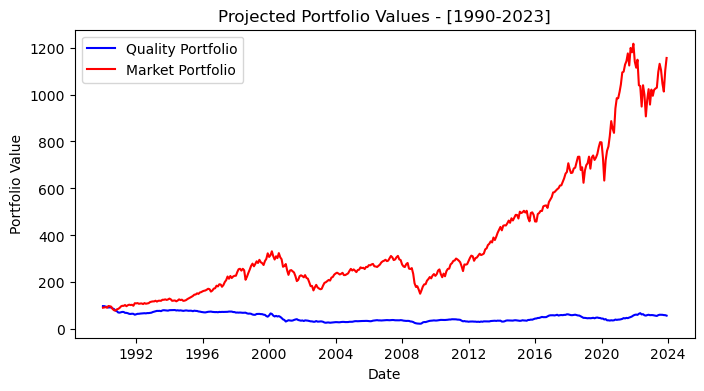

In [111]:
cumulative_returns1 = (1 + Quality_FF['H-L']).cumprod() 
cumulative_returns2 = (1 + Quality_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

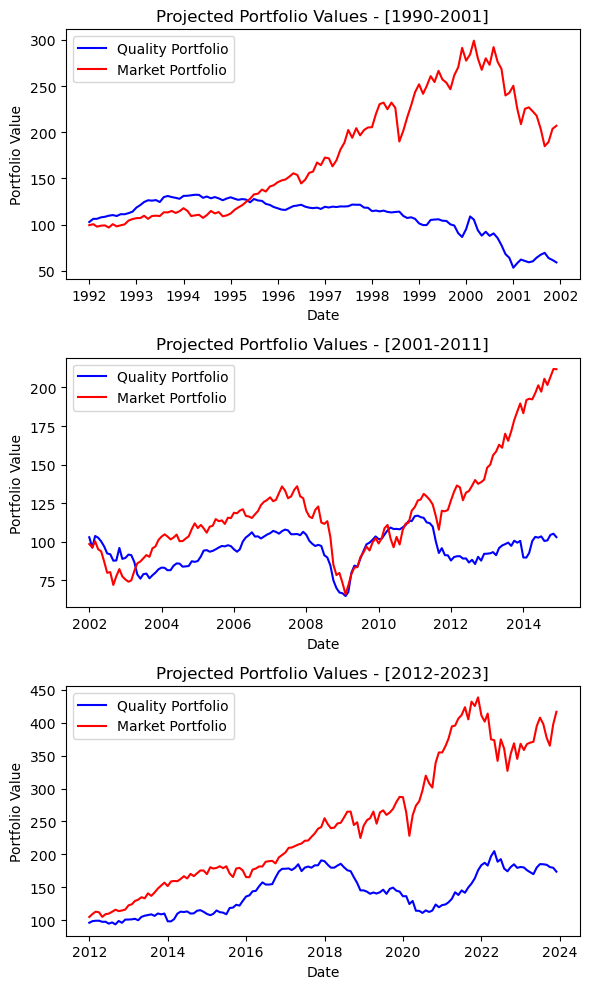

In [112]:
cumulative_returns1_1 = (1 + Quality_FF['H-L']['1992':'2001']).cumprod()
cumulative_returns2_1 = (1 + Quality_FF['mktrf']['1992':'2001']).cumprod()

cumulative_returns1_1.index = cumulative_returns1_1.index.to_timestamp()
cumulative_returns2_1.index = cumulative_returns2_1.index.to_timestamp()

initial_value = 100

portfolio_value1_1 = cumulative_returns1_1 * initial_value
portfolio_value2_1 = cumulative_returns2_1 * initial_value

cumulative_returns1_2 = (1 + Quality_FF['H-L']['2002':'2014']).cumprod()
cumulative_returns2_2 = (1 + Quality_FF['mktrf']['2002':'2014']).cumprod()

cumulative_returns1_2.index = cumulative_returns1_2.index.to_timestamp()
cumulative_returns2_2.index = cumulative_returns2_2.index.to_timestamp()

portfolio_value1_2 = cumulative_returns1_2 * initial_value
portfolio_value2_2 = cumulative_returns2_2 * initial_value

cumulative_returns1_3 = (1 + Quality_FF['H-L']['2012':]).cumprod()
cumulative_returns2_3 = (1 + Quality_FF['mktrf']['2012':]).cumprod() 

cumulative_returns1_3.index = cumulative_returns1_3.index.to_timestamp()
cumulative_returns2_3.index = cumulative_returns2_3.index.to_timestamp()

portfolio_value1_3 = cumulative_returns1_3 * initial_value
portfolio_value2_3 = cumulative_returns2_3 * initial_value

# Create subplots
fig, axs = plt.subplots(3, figsize=(6, 10))

# Plot each graph on its respective subplot
axs[0].plot(portfolio_value1_1, color='blue', linestyle='-', label='Quality Portfolio')
axs[0].plot(portfolio_value2_1, color='red', linestyle='-', label='Market Portfolio')
axs[0].set_title('Projected Portfolio Values - [1990-2001]')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Portfolio Value')
axs[0].legend()

axs[1].plot(portfolio_value1_2, color='blue', linestyle='-', label='Quality Portfolio')
axs[1].plot(portfolio_value2_2, color='red', linestyle='-', label='Market Portfolio')
axs[1].set_title('Projected Portfolio Values - [2001-2011]')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Portfolio Value')
axs[1].legend()

axs[2].plot(portfolio_value1_3, color='blue', linestyle='-', label='Quality Portfolio')
axs[2].plot(portfolio_value2_3, color='red', linestyle='-', label='Market Portfolio')
axs[2].set_title('Projected Portfolio Values - [2012-2023]')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Portfolio Value')
axs[2].legend()

plt.tight_layout()
plt.show()


### 2.1.5 Regressions Quality

**1) CAPM**

In [113]:
def CAPM_regression(portfolio_df, Quality_FF):
    factors_CAPM = Quality_FF['mktrf']
    regression_results_CAPM = pd.DataFrame(index=['Alpha CAPM', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_CAPM = sm.add_constant(factors_CAPM)

        model = sm.OLS(portfolio_returns, X_CAPM)
        results = model.fit()

        regression_results_CAPM.loc['Alpha CAPM', portfolio] = results.params[0]
        regression_results_CAPM.loc['Alpha t-stat', portfolio] = results.tvalues[0]
        regression_results_CAPM.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_CAPM.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_CAPM.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_CAPM

In [114]:
CAPM_Quality = CAPM_regression(portfolio_df,Quality_FF)
CAPM_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,-0.000478,0.002505,0.003126,0.002541,0.00317,0.004161,0.005165,0.003762,0.001453,-0.000265,-0.001939
Alpha t-stat,-0.199101,1.970256,2.455752,1.721821,1.923859,2.154796,2.67908,2.110057,0.737278,-0.121499,-1.06476
β_Mkt-RF,1.167634,0.995424,1.031227,1.107205,1.130601,1.18664,1.267425,1.182064,1.2592,1.352746,0.187079
Mkt-RF t-stat,21.892592,35.248793,36.480998,33.784879,30.898078,27.673115,29.599807,29.856044,28.765834,27.902105,4.624861
Adj.R2,0.540261,0.753106,0.76567,0.736981,0.700887,0.652671,0.682564,0.686292,0.670037,0.656403,0.047707


**2) FF-3**

In [115]:
def FF3_regression(portfolio_df, Quality_FF):
    factors_FF3 = Quality_FF[['mktrf', 'smb', 'hml']]
    regression_results_FF3 = pd.DataFrame(index=['Alpha FF3', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML',  'HML t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF3 = sm.add_constant(factors_FF3)

        model = sm.OLS(portfolio_returns, X_FF3)
        results = model.fit()

        regression_results_FF3.loc['Alpha FF3', portfolio] = results.params[0] 
        regression_results_FF3.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_FF3.loc['β_SMB', portfolio] = results.params[2]
        regression_results_FF3.loc['β_HML', portfolio] = results.params[3]
        
        regression_results_FF3.loc['Alpha t-stat', portfolio] = results.tvalues[0] 
        regression_results_FF3.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_FF3.loc['SMB t-stat', portfolio] = results.tvalues[2]
        regression_results_FF3.loc['HML t-stat', portfolio] = results.tvalues[3]

        regression_results_FF3.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF3

In [116]:
FF3_Quality = FF3_regression(portfolio_df, Quality_FF)
FF3_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,-0.000293,0.002457,0.002943,0.002348,0.00304,0.003934,0.0051,0.003476,0.001041,-0.000685,-0.002544
Alpha t-stat,-0.144738,2.876302,4.001406,2.579639,3.021702,3.094426,3.964583,3.090345,0.783129,-0.451113,-1.459367
β_Mkt-RF,1.014567,0.891608,0.923137,0.985676,0.989779,1.033732,1.108793,1.040347,1.116447,1.1974,0.184095
Mkt-RF t-stat,21.8473,45.425831,54.627112,47.126652,42.817229,35.391891,37.515383,40.258516,36.570635,34.315823,4.596326
β_SMB,0.872014,0.633565,0.691718,0.774604,0.874958,0.970858,0.9661,0.918134,0.955018,1.032199,0.164203
SMB t-stat,12.985286,22.321909,28.306268,25.610808,26.174515,22.98598,22.604368,24.569521,21.633023,20.45645,2.835052
β_HML,-0.118156,0.00616,0.072105,0.074682,0.04021,0.086283,0.005336,0.117524,0.180176,0.181593,0.299231
HML t-stat,-1.927943,0.237818,3.233183,2.705644,1.318073,2.238432,0.136797,3.446079,4.472095,3.943435,5.661014
Adj.R2,0.675539,0.888973,0.92204,0.900272,0.888872,0.849986,0.859208,0.87559,0.850602,0.834315,0.130862


**3) FF-5**

In [117]:
def FF5_regression(portfolio_df, Quality_FF):
    factors_FF5 = Quality_FF[['mktrf', 'smb', 'hml', 'rmw', 'cma']]
    regression_results_FF5 = pd.DataFrame(index=['Alpha FF5', 'Alpha t-stat', 'β_Mkt-RF', 'Mkt-RF t-stat', 'β_SMB', 'SMB t-stat', 'β_HML', 'HML t-stat', 'β_RMW', 'RMW t-stat', 'β_CMA', 'CMA t-stat', 'Adj.R2'], columns=portfolio_df.columns)

    for portfolio in portfolio_df.columns:
        portfolio_returns = portfolio_df[portfolio]

        X_FF5 = sm.add_constant(factors_FF5)

        model = sm.OLS(portfolio_returns, X_FF5)
        results = model.fit()

        regression_results_FF5.loc['Alpha FF5', portfolio] = results.params[0] 
        regression_results_FF5.loc['β_Mkt-RF', portfolio] = results.params[1]
        regression_results_FF5.loc['β_SMB', portfolio] = results.params[2]
        regression_results_FF5.loc['β_HML', portfolio] = results.params[3]
        regression_results_FF5.loc['β_RMW', portfolio] = results.params[4]
        regression_results_FF5.loc['β_CMA', portfolio] = results.params[5]
        
        regression_results_FF5.loc['Alpha t-stat', portfolio] = results.tvalues[0] 
        regression_results_FF5.loc['Mkt-RF t-stat', portfolio] = results.tvalues[1]
        regression_results_FF5.loc['SMB t-stat', portfolio] = results.tvalues[2]
        regression_results_FF5.loc['HML t-stat', portfolio] = results.tvalues[3]
        regression_results_FF5.loc['RMW t-stat', portfolio] = results.tvalues[4]
        regression_results_FF5.loc['CMA t-stat', portfolio] = results.tvalues[5]

        regression_results_FF5.loc['Adj.R2', portfolio] = results.rsquared_adj

    return regression_results_FF5

In [118]:
FF5_Quality = FF5_regression(portfolio_df, Quality_FF)
FF5_Quality

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.000763,0.002224,0.00275,0.00253,0.0033,0.004292,0.00644,0.0042,0.002083,0.000381,-0.002545
Alpha t-stat,0.364552,2.515792,3.603642,2.713069,3.19643,3.267677,4.965883,3.650702,1.554027,0.247065,-1.420134
β_Mkt-RF,0.978261,0.894005,0.932489,0.991457,0.99302,1.031297,1.077917,1.027229,1.100513,1.181358,0.204948
Mkt-RF t-stat,19.22837,41.59328,50.250783,43.732791,39.559769,32.291554,34.185613,36.722766,33.760216,31.523237,4.704223
β_SMB,0.820454,0.659135,0.694293,0.735471,0.831602,0.928449,0.862321,0.853057,0.85383,0.92816,0.111745
SMB t-stat,10.97914,20.87776,25.472336,22.086413,22.554748,19.792006,18.618887,20.762161,17.832331,16.861599,1.746223
β_HML,-0.020533,0.005918,0.043963,0.045887,0.018073,0.081929,0.071586,0.139797,0.201032,0.201984,0.22019
HML t-stat,-0.238551,0.162735,1.400358,1.196378,0.425572,1.516323,1.341944,2.95404,3.645236,3.18578,2.987387
β_RMW,-0.154199,0.069958,0.010847,-0.103122,-0.115569,-0.115386,-0.292759,-0.180975,-0.279533,-0.287269,-0.132768
RMW t-stat,-1.641771,1.763041,0.31662,-2.463926,-2.49391,-1.957059,-5.029344,-3.504539,-4.645019,-4.152235,-1.65075


## 2.2 - Momentum Strategy

In [119]:
stk_data

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10000,1987-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987
1,10000,1987-02,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987
2,10000,1987-03,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987
3,10000,1987-04,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987
4,10000,1987-05,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3409591,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3409592,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3409593,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


First of all we drop observations without returns data:

In [120]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

In [121]:
Momentum_df = stk_data
Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')

/var/folders/lv/4s79bs8j60n07b1d88ptj5l00000gn/T/ipykernel_28398/3862814677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Momentum_df['date'] = pd.to_datetime(Momentum_df['date'], format='%Y-%m-%d')


In [122]:
Momentum_df = preprocess_dataframe(Momentum_df)

### 2.2.1 Building "Momentum Score"

Momentum was built based on "Is momentum really momentum?" by Novy-Marx, Robert, (2012) where they find the biggest results regarding the MOM12-7, so the returns based on the 12th to 7th months prior. We experimented on two ways of builiding the mom factor through the growth rate and through the comulative sum (GR, CUM).

In [123]:
Momentum_df = Momentum_df.sort_values(by=['PERMNO', 'date'])

window_size = 12

Momentum_df['PRC_7M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size - 5)  # Price at 7 months prior
Momentum_df['PRC_12M'] = Momentum_df.groupby('PERMNO')['PRC'].shift(window_size)  # Price at 12 months prior

Momentum_df['MOM12-7(GR)'] = (Momentum_df['PRC_7M'] - Momentum_df['PRC_12M']) / Momentum_df['PRC_12M']

Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR)
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987,NaN,NaN,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987,NaN,NaN,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987,NaN,NaN,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987,NaN,NaN,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,173.22000,275.60999,-0.371503
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,205.71001,265.25000,-0.224467
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,207.46001,227.53999,-0.088248
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,164.31000,194.70000,-0.156086


In [124]:
Momentum_df =Momentum_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['MOM12-7(CUM)'] = group['RET'].shift(7).rolling(window=6).sum()
    return group

Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)

Momentum_df

/var/folders/lv/4s79bs8j60n07b1d88ptj5l00000gn/T/ipykernel_28398/616378836.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Momentum_df = Momentum_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR),MOM12-7(CUM)
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987,NaN,NaN,NaN,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987,NaN,NaN,NaN,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987,NaN,NaN,NaN,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987,NaN,NaN,NaN,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,173.22000,275.60999,-0.371503,-0.357671
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,205.71001,265.25000,-0.224467,-0.097617
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,207.46001,227.53999,-0.088248,-0.051521
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,164.31000,194.70000,-0.156086,-0.117345


### 2.2.2 Momentum Deciles Sorting

The deciles are created based on the comulative sum of the stock returns of the 12-7 months. 

In [125]:
Momentum_df = Momentum_df.sort_values(by='MOM12-7(CUM)', ascending=False)
Momentum_df.dropna(subset=['MOM12-7(CUM)'], inplace=True)
Momentum_df['deciles_Q'] = Momentum_df.groupby(['date'])['MOM12-7(CUM)'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
Momentum_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,PRC_7M,PRC_12M,MOM12-7(GR),MOM12-7(CUM),deciles_Q
1277712,58748,1992-08-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.68750,0.047619,16297.0,-0.020819,11204.1875,1992,1.17188,0.04688,23.997440,24.000000,10
1277713,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.53125,-0.227273,16822.0,0.012461,8936.6875,1992,1.14063,0.04688,23.330845,23.973333,10
1277714,58748,1992-10-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.50000,-0.058824,16822.0,0.010983,8411.0000,1992,0.79688,0.04688,15.998294,23.671963,10
1277715,58748,1992-11-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.75000,0.500000,16822.0,0.040181,12616.5000,1992,0.78125,0.04688,15.664889,23.652355,10
1277716,58748,1992-12-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.50000,-0.333333,17755.0,0.017740,8877.5000,1992,0.71875,0.04688,14.331698,23.572355,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486964,84521,2007-12-01,11.0,2.0,2836.0,CARDIUM THERAPEUTICS INC,2.60000,-0.018868,40935.0,-0.004405,106431.0000,2007,0.03125,4.59375,-0.993197,-3.116634,1
2897789,89169,2020-09-01,11.0,3.0,3841.0,DELCATH SYSTEMS INC,11.61000,-0.024370,4036.0,-0.035056,46857.9600,2020,0.02110,0.92000,-0.977065,-3.118186,1
3327740,92687,2017-09-01,11.0,3.0,8711.0,REAL GOODS SOLAR INC,0.87000,0.108280,7481.0,0.023729,6508.4700,2017,1.68000,3.81000,-0.559055,-3.276644,1
3314615,92571,2020-06-01,11.0,2.0,1311.0,CAMBER ENERGY INC,1.19000,-0.070312,12456.0,0.025299,14822.6400,2020,0.85610,0.15130,4.658295,-3.414555,1


### 2.2.3 Momentum Deciles Portfolios Returns

Portfolio returns based on momentum are also value-weighted (compute_deciles_port_equally function does that). 

In [126]:
portfolio_mom = compute_deciles_port_equally(Momentum_df)
portfolio_mom['H-L'] = portfolio_mom['P10'] - portfolio_mom['P1']
portfolio_mom.index = pd.to_datetime(portfolio_mom.index, format="%Y-%m-%d").to_period('M')
portfolio_mom = portfolio_mom['1990':]
portfolio_mom

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
date,,,,,,,,,,,
1990-01,-0.003964,-0.024314,-0.051554,-0.046470,-0.049246,-0.052821,-0.063569,-0.071227,-0.075604,-0.071930,-0.067966
1990-02,0.047525,0.007127,0.016397,0.011851,0.014880,0.022868,0.012901,0.019671,0.021933,0.018983,-0.028542
1990-03,0.004196,0.029197,0.006493,0.018821,0.023664,0.019702,0.025642,0.031795,0.041176,0.048911,0.044715
1990-04,-0.004097,-0.032310,-0.024699,-0.021738,-0.027395,-0.025509,-0.030671,-0.037838,-0.039584,-0.021312,-0.017215
1990-05,0.041078,0.031279,0.031970,0.027100,0.033123,0.044659,0.049011,0.061297,0.066206,0.068693,0.027615
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.134072,-0.090640,-0.075790,-0.065963,-0.031077,-0.042915,-0.041804,-0.052894,-0.047880,-0.080581,0.053490
2023-09,-0.126415,-0.088794,-0.087995,-0.062041,-0.047146,-0.040634,-0.056316,-0.056049,-0.065322,-0.057706,0.068709
2023-10,-0.164445,-0.121003,-0.060742,-0.062504,-0.055601,-0.069545,-0.052215,-0.058171,-0.067029,-0.064973,0.099472


We subtract risk free rate in order to have the excess returns.

In [127]:
portfolio_mom = portfolio_mom.sub(rf, axis=0)

Momentum_FF = pd.concat([portfolio_mom, FF_data], axis=1)
Momentum_FF = Momentum_FF['1990':]
Momentum_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.009664,-0.030014,-0.057254,-0.052170,-0.054946,-0.058521,-0.069269,-0.076927,-0.081304,-0.077630,-0.073666,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.041825,0.001427,0.010697,0.006151,0.009180,0.017168,0.007201,0.013971,0.016233,0.013283,-0.034242,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,-0.002204,0.022797,0.000093,0.012421,0.017264,0.013302,0.019242,0.025395,0.034776,0.042511,0.038315,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.010997,-0.039210,-0.031599,-0.028638,-0.034295,-0.032409,-0.037571,-0.044738,-0.046484,-0.028212,-0.024115,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.034278,0.024479,0.025170,0.020300,0.026323,0.037859,0.042211,0.054497,0.059406,0.061893,0.020815,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.138572,-0.095140,-0.080290,-0.070463,-0.035577,-0.047415,-0.046304,-0.057394,-0.052380,-0.085081,0.048990,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.130715,-0.093094,-0.092295,-0.066341,-0.051446,-0.044934,-0.060616,-0.060349,-0.069622,-0.062006,0.064409,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.169145,-0.125703,-0.065442,-0.067204,-0.060301,-0.074245,-0.056915,-0.062871,-0.071729,-0.069673,0.094772,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


### 2.2.4 Return Analysis

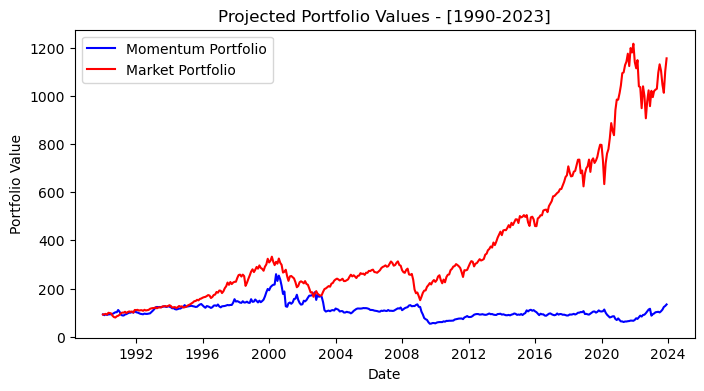

In [128]:
cumulative_returns1 = (1 + Momentum_FF['H-L']).cumprod() 
cumulative_returns2 = (1 + Momentum_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Momentum Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.2.5 Regressions Momentum

**1) CAPM**

In [129]:
CAPM_MOM = CAPM_regression(portfolio_mom, Momentum_FF)
CAPM_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha CAPM,-0.003473,-0.001091,-0.000539,0.001451,0.00271,0.003079,0.003995,0.003773,0.002719,0.001825,0.003146
Alpha t-stat,-0.953927,-0.474651,-0.32058,1.040068,2.101121,2.482509,3.179357,2.806795,1.65295,0.730415,1.175922
β_Mkt-RF,1.51524,1.236538,1.121391,1.003358,0.971372,0.931007,0.944773,0.998448,1.130074,1.382821,-0.130453
Mkt-RF t-stat,18.740438,24.223102,30.053424,32.381146,33.910012,33.80214,33.852815,33.445401,30.930928,24.922022,-2.195918
Adj.R2,0.462496,0.590031,0.689125,0.720186,0.738413,0.737179,0.73776,0.733044,0.701333,0.603741,0.009303


**2) FF-3**

In [130]:
FF3_MOM = FF3_regression(portfolio_mom, Momentum_FF)
FF3_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF3,-0.003341,-0.001413,-0.001096,0.000861,0.002076,0.00254,0.003597,0.003554,0.002771,0.002297,0.003487
Alpha t-stat,-1.099661,-0.809305,-0.952161,0.99247,2.76154,3.63144,4.729904,4.406943,2.681326,1.318663,1.311269
β_Mkt-RF,1.283577,1.083478,1.015819,0.916746,0.894365,0.848703,0.854422,0.888131,0.984401,1.167511,-0.114803
Mkt-RF t-stat,18.387422,27.017842,38.415924,45.971459,51.773494,52.808611,48.898583,47.932704,41.457942,29.172801,-1.879234
β_SMB,1.35584,0.994704,0.767264,0.66156,0.614699,0.623397,0.637618,0.71385,0.86012,1.175565,-0.176258
SMB t-stat,13.431329,17.152842,20.065537,22.941397,24.607454,26.82409,25.234557,26.642379,25.049913,20.313058,-1.995208
β_HML,-0.104951,0.133242,0.258178,0.277542,0.301056,0.252966,0.181973,0.08973,-0.050528,-0.270767,-0.166334
HML t-stat,-1.139217,2.517626,7.398342,10.54602,13.205667,11.927008,7.891347,3.669568,-1.612458,-5.126641,-2.063146
Adj.R2,0.627021,0.764474,0.854664,0.892113,0.911444,0.916699,0.904305,0.904268,0.882566,0.808096,0.024752


**3) FF-5**

In [131]:
FF5_MOM = FF5_regression(portfolio_mom,Momentum_FF)
FF5_MOM

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,H-L
Alpha FF5,0.00074,0.000709,-0.000552,0.001014,0.002046,0.002426,0.003548,0.003858,0.003875,0.00535,0.002448
Alpha t-stat,0.244157,0.400382,-0.464134,1.124912,2.6349,3.339148,4.498212,4.648082,3.767378,3.267324,0.887754
β_Mkt-RF,1.174997,1.014123,0.991274,0.908255,0.888534,0.850845,0.860361,0.885446,0.963352,1.100184,-0.072962
Mkt-RF t-stat,15.939058,23.56913,34.254657,41.453402,47.06099,48.156715,44.858489,43.872424,38.515135,27.631436,-1.0884
β_SMB,1.076267,0.881967,0.755447,0.662315,0.633493,0.633422,0.629295,0.679399,0.763481,0.931373,-0.140855
SMB t-stat,9.939684,13.955061,17.772842,20.579928,22.843139,24.407687,22.338033,22.918234,20.781229,15.925342,-1.430504
β_HML,0.151924,0.315745,0.330627,0.30396,0.324313,0.249163,0.161313,0.088376,-0.012609,-0.131313,-0.285563
HML t-stat,1.21815,4.337492,6.753275,8.20009,10.153169,8.335651,4.971459,2.588286,-0.29797,-1.949373,-2.517927
β_RMW,-0.799274,-0.332977,-0.042109,-0.001507,0.048251,0.02793,-0.019966,-0.094028,-0.269404,-0.686638,0.112938
RMW t-stat,-5.873074,-4.191902,-0.788224,-0.037249,1.384311,0.856285,-0.563909,-2.523655,-5.834377,-9.341356,0.912592


## 2.3 Low Volatility Strategy

In [132]:
stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')
stk_data = stk_data.dropna(subset=['RET']) # Dropping rows with NaN values in 'RET'

/var/folders/lv/4s79bs8j60n07b1d88ptj5l00000gn/T/ipykernel_28398/115396609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stk_data['RET'] = pd.to_numeric(stk_data['RET'], errors='coerce')


In [133]:
LowVol_df = stk_data
LowVol_df['date'] = pd.to_datetime(LowVol_df['date'], format='%Y-%m-%d')

In [134]:
LowVol_df = preprocess_dataframe(LowVol_df)
LowVol_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987
...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023


### 2.3.1 Building Low-Volatility Score

In [135]:
LowVol_df = LowVol_df.sort_values(by=['PERMNO', 'date'])

def compute_rolling_sum(group):
    group['RET_VAR'] = group['RET'].rolling(window=36).var()
    return group

LowVol_df = LowVol_df.groupby('PERMNO').apply(compute_rolling_sum)
LowVol_df

/var/folders/lv/4s79bs8j60n07b1d88ptj5l00000gn/T/ipykernel_28398/967580346.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  LowVol_df = LowVol_df.groupby('PERMNO').apply(compute_rolling_sum)


,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,RET_VAR
0,10000,1987-01-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,-0.212121,3893.0,0.128499,1.581531e+03,1987,NaN
1,10000,1987-02-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.40625,0.000000,3893.0,0.047922,1.581531e+03,1987,NaN
2,10000,1987-03-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.25000,-0.384615,3893.0,0.023664,9.732500e+02,1987,NaN
3,10000,1987-04-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.23438,-0.062500,3893.0,-0.016996,9.124413e+02,1987,NaN
4,10000,1987-05-01,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,0.21875,-0.066667,3893.0,0.005123,8.515938e+02,1987,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409590,93436,2023-08-01,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,-0.020605,8.191443e+08,2023,0.038574
3409591,93436,2023-09-01,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,-0.047390,7.954494e+08,2023,0.037853
3409592,93436,2023-10-01,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,-0.028867,6.384545e+08,2023,0.038888
3409593,93436,2023-11-01,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,0.092057,7.631954e+08,2023,0.034263


### 2.3.2 Volatility Deciles Sorting

In the low vol strategy we follow the Blitz et al (2007) methodology considering the variance of the previous 36 months to rank stocks in deciles.

In [136]:
LowVol_df = LowVol_df.sort_values(by='RET_VAR', ascending=True)
LowVol_df.dropna(subset=['RET_VAR'], inplace=True)
LowVol_df['deciles_Q'] = LowVol_df.groupby(['date'])['RET_VAR'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
LowVol_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,vwretd,MktCap_Mon,Year,RET_VAR,deciles_Q
1130646,47504,1992-03-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,-0.023699,10530.00000,1992,0.000042,1
1130645,47504,1992-02-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,0.013355,10530.00000,1992,0.000048,1
1130644,47504,1992-01-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,-0.001164,10530.00000,1992,0.000048,1
1130643,47504,1991-12-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,810.0,0.106782,10530.00000,1991,0.000048,1
1130642,47504,1991-11-01,10.0,3.0,6710.0,KENTUCKY INVESTORS INC,13.00000,0.000000,816.0,-0.037291,10608.00000,1991,0.000048,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277713,58748,1992-09-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.53125,-0.227273,16822.0,0.012461,8936.68750,1992,16.214424,10
1277711,58748,1992-07-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.65625,-0.045455,16297.0,0.039900,10694.90625,1992,16.215726,10
1277709,58748,1992-05-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.71875,-0.080000,16184.0,0.006407,11632.25000,1992,16.216260,10
1277710,58748,1992-06-01,11.0,3.0,3840.0,O C G TECHNOLOGY INC,0.68750,-0.043478,16297.0,-0.019258,11204.18750,1992,16.216646,10


### 2.3.3 Volatility Deciles Portfolios Returns

In [137]:
portfolio_LowVol = compute_deciles_port_equally(LowVol_df)
portfolio_LowVol['L-H'] = portfolio_LowVol['P1'] - portfolio_LowVol['P10']
portfolio_LowVol.index = pd.to_datetime(portfolio_LowVol.index, format="%Y-%m-%d").to_period('M')
portfolio_LowVol = portfolio_LowVol['1990':]
portfolio_LowVol

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
date,,,,,,,,,,,
1990-01,-0.040964,-0.055691,-0.060924,-0.070404,-0.075341,-0.063141,-0.076080,-0.074895,-0.066843,0.064292,-0.105257
1990-02,0.000749,0.008970,0.012437,0.012773,0.019200,0.021802,0.009740,0.014970,0.027190,0.068236,-0.067488
1990-03,0.002265,0.013888,0.014620,0.015293,0.028059,0.030417,0.019651,0.034578,0.032094,0.051035,-0.048769
1990-04,-0.028006,-0.031286,-0.030455,-0.024152,-0.032854,-0.046473,-0.041740,-0.028642,-0.032640,-0.000121,-0.027885
1990-05,0.020902,0.039146,0.037032,0.049971,0.045532,0.044363,0.048200,0.037955,0.045562,0.077946,-0.057044
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.029369,-0.023832,-0.041163,-0.030452,-0.040218,-0.053665,-0.057539,-0.085788,-0.117810,-0.119115,0.089746
2023-09,-0.035096,-0.036501,-0.046313,-0.059628,-0.054114,-0.060460,-0.079777,-0.077588,-0.101935,-0.101003,0.065907
2023-10,-0.012595,-0.022322,-0.043544,-0.054269,-0.071240,-0.068266,-0.088628,-0.115935,-0.115077,-0.104711,0.092116


In [138]:
portfolio_LowVol = portfolio_LowVol.sub(rf, axis=0)
LowVol_FF = pd.concat([portfolio_LowVol, FF_data], axis=1)
LowVol_FF = LowVol_FF['1990':]
LowVol_FF

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.046664,-0.061391,-0.066624,-0.076104,-0.081041,-0.068841,-0.081780,-0.080595,-0.072543,0.058592,-0.110957,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,-0.004951,0.003270,0.006737,0.007073,0.013500,0.016102,0.004040,0.009270,0.021490,0.062536,-0.073188,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,-0.004135,0.007488,0.008220,0.008893,0.021659,0.024017,0.013251,0.028178,0.025694,0.044635,-0.055169,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.034906,-0.038186,-0.037355,-0.031052,-0.039754,-0.053373,-0.048640,-0.035542,-0.039540,-0.007021,-0.034785,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,0.014102,0.032346,0.030232,0.043171,0.038732,0.037563,0.041400,0.031155,0.038762,0.071146,-0.063844,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,-0.033869,-0.028332,-0.045663,-0.034952,-0.044718,-0.058165,-0.062039,-0.090288,-0.122310,-0.123615,0.085246,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.039396,-0.040801,-0.050613,-0.063928,-0.058414,-0.064760,-0.084077,-0.081888,-0.106235,-0.105303,0.061607,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,-0.017295,-0.027022,-0.048244,-0.058969,-0.075940,-0.072966,-0.093328,-0.120635,-0.119777,-0.109411,0.087416,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


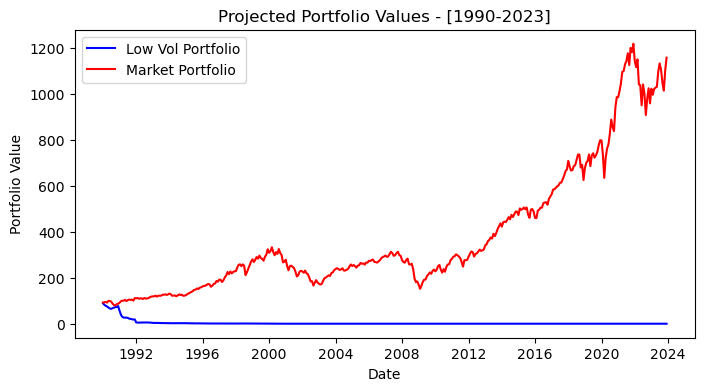

In [139]:
cumulative_returns1 = (1 + LowVol_FF['L-H']).cumprod() 
cumulative_returns2 = (1 + LowVol_FF['mktrf']).cumprod() 

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Low Vol Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Projected Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.3.4 Regressions Low Vol

**1) CAPM**

In [140]:
CAPM_LOWVOL = CAPM_regression(portfolio_LowVol, LowVol_FF)
CAPM_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha CAPM,0.0036,0.002901,0.00181,0.001481,0.00008,-0.000472,-0.002354,-0.003733,-0.002077,0.022585,-0.021137
Alpha t-stat,4.595444,3.089333,1.69833,1.271684,0.064073,-0.330844,-1.347112,-1.681541,-0.684394,4.047295,-3.634243
β_Mkt-RF,0.431667,0.65856,0.794518,0.897301,1.006527,1.106418,1.234836,1.38368,1.552266,1.914581,-1.480948
Mkt-RF t-stat,24.811877,31.584169,33.572965,34.697602,36.127,34.916713,31.821503,28.064071,23.035356,15.449122,-11.465409
Adj.R2,0.601617,0.710023,0.734532,0.747193,0.76215,0.749566,0.713099,0.659012,0.565462,0.368675,0.242728


**2) FF-3**

In [141]:
FF3_LOWVOL = FF3_regression(portfolio_LowVol, LowVol_FF)
FF3_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha FF3,0.003065,0.00214,0.000952,0.000618,-0.000638,-0.001027,-0.002825,-0.003971,-0.001899,0.02354,-0.022626
Alpha t-stat,4.776515,3.404576,1.517862,0.964487,-0.930013,-1.290882,-2.800988,-2.780296,-0.892856,5.266073,-4.763349
β_Mkt-RF,0.440443,0.653419,0.772643,0.856688,0.937389,1.005762,1.099359,1.203504,1.30242,1.510291,-1.068585
Mkt-RF t-stat,29.875099,45.250707,53.623246,58.226675,59.50717,55.016753,47.449533,36.675006,26.659245,14.705125,-9.791079
β_SMB,0.076918,0.214917,0.338646,0.452183,0.587926,0.73729,0.925477,1.136879,1.453572,2.190734,-2.109798
SMB t-stat,3.607954,10.292386,16.252926,21.253196,25.809736,27.890063,27.622908,23.957874,20.575235,14.750581,-13.368229
β_HML,0.266736,0.376253,0.421515,0.420954,0.344111,0.257947,0.210183,0.087102,-0.130984,-0.542497,0.808715
HML t-stat,13.709527,19.74398,22.167051,21.679744,16.552702,10.691778,6.874009,2.011278,-2.031587,-4.002452,5.614842
Adj.R2,0.73369,0.870536,0.908391,0.923824,0.929218,0.922406,0.904792,0.859386,0.787384,0.596353,0.496716


**3) FF-5**

In [142]:
FF5_LOWVOL = FF5_regression(portfolio_LowVol,LowVol_FF)
FF5_LOWVOL

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,L-H
Alpha FF5,0.001677,0.000772,-0.000311,-0.00054,-0.001477,-0.001086,-0.002039,-0.002255,0.001539,0.030366,-0.030851
Alpha t-stat,2.730601,1.337243,-0.544465,-0.926453,-2.230651,-1.331026,-1.96519,-1.578555,0.761197,7.132965,-6.872582
β_Mkt-RF,0.488189,0.68864,0.801251,0.879088,0.950646,0.997489,1.069406,1.162332,1.22939,1.374511,-0.884472
Mkt-RF t-stat,32.69127,49.031937,57.635784,62.058424,59.048281,50.275042,42.385639,33.46754,25.014085,13.278881,-8.10322
β_SMB,0.144729,0.311486,0.437767,0.552599,0.668275,0.766124,0.894498,1.008011,1.171748,1.607771,-1.459003
SMB t-stat,6.598231,15.099145,21.438433,26.558621,28.259907,26.28876,24.136949,19.759942,16.23139,10.574602,-9.100318
β_HML,0.138353,0.294573,0.360963,0.379924,0.325683,0.29155,0.293958,0.178108,0.015538,-0.286585,0.422611
HML t-stat,5.476226,12.397355,15.347462,15.853135,11.957315,8.685753,6.886709,3.031286,0.186872,-1.636502,2.288571
β_RMW,0.2028,0.275129,0.279249,0.280154,0.22222,0.074307,-0.096043,-0.364715,-0.790507,-1.628812,1.831914
RMW t-stat,7.356242,10.611264,10.880741,10.712962,7.476806,2.028708,-2.06199,-5.688419,-8.71253,-8.523693,9.091228
